<a href="https://colab.research.google.com/github/Bhavya232003/Bhavya232003/blob/main/Terrain_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os, zipfile

# Upload your "dem_dataset .zip" file (note the space!)
uploaded = files.upload()

# Path with the same name as uploaded
zip_path = "/content/dem_dataset .zip"
extract_path = "/content/dem_dataset"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Show top-level structure
print("Top-level folders:", os.listdir(extract_path))


Saving dem_dataset .zip to dem_dataset .zip
Top-level folders: ['dem_dataset']


In [3]:
import os

# Correct path
extract_path = "/content/dem_dataset/dem_dataset"

# Find ALOS and SRTM folders
alos_path = [os.path.join(extract_path, f) for f in os.listdir(extract_path) if "ALOS" in f and os.path.isdir(os.path.join(extract_path, f))][0]
srtm_path = [os.path.join(extract_path, f) for f in os.listdir(extract_path) if "SRTM" in f and os.path.isdir(os.path.join(extract_path, f))][0]

print("ALOS path:", alos_path)
print("SRTM path:", srtm_path)

print("ALOS tiles:", len(os.listdir(alos_path)))
print("SRTM tiles:", len(os.listdir(srtm_path)))

# Show sample files
print("Sample ALOS files:", os.listdir(alos_path)[:3])
print("Sample SRTM files:", os.listdir(srtm_path)[:3])


ALOS path: /content/dem_dataset/dem_dataset/ALOS-20250824T134844Z-1-001
SRTM path: /content/dem_dataset/dem_dataset/SRTM-20250824T134849Z-1-001
ALOS tiles: 1
SRTM tiles: 1
Sample ALOS files: ['ALOS']
Sample SRTM files: ['SRTM']


In [8]:
!pip install rasterio

Using file: /content/dem_dataset/dem_dataset/ALOS-20250824T134844Z-1-001/ALOS/alos_205.tif


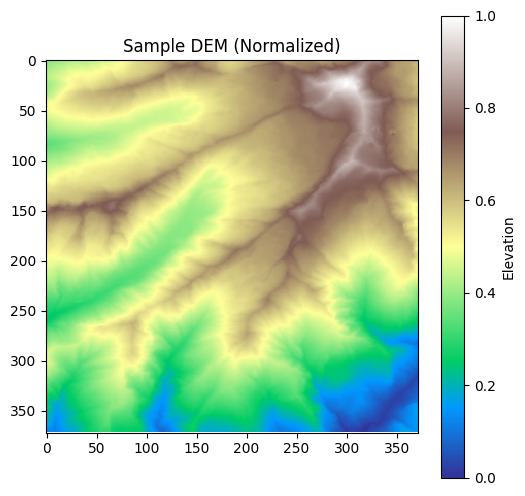

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

# Correct ALOS folder path
alos_path = "/content/dem_dataset/dem_dataset/ALOS-20250824T134844Z-1-001/ALOS"

# Pick the first GeoTIFF file
sample_tile = None
for file_name in os.listdir(alos_path):
    if file_name.lower().endswith(('.tif', '.tiff', '.img', '.jp2')):
        sample_tile = os.path.join(alos_path, file_name)
        break

if sample_tile:
    print("Using file:", sample_tile)
    with rasterio.open(sample_tile) as src:
        dem = src.read(1).astype(np.float32)

    # Normalize DEM values
    dem_norm = (dem - np.min(dem)) / (np.max(dem) - np.min(dem))

    # Visualize DEM
    plt.figure(figsize=(6,6))
    plt.title("Sample DEM (Normalized)")
    plt.imshow(dem_norm, cmap="terrain")
    plt.colorbar(label="Elevation")
    plt.show()
else:
    print("No supported raster files found in the ALOS directory.")


Total patches: (25, 64, 64)


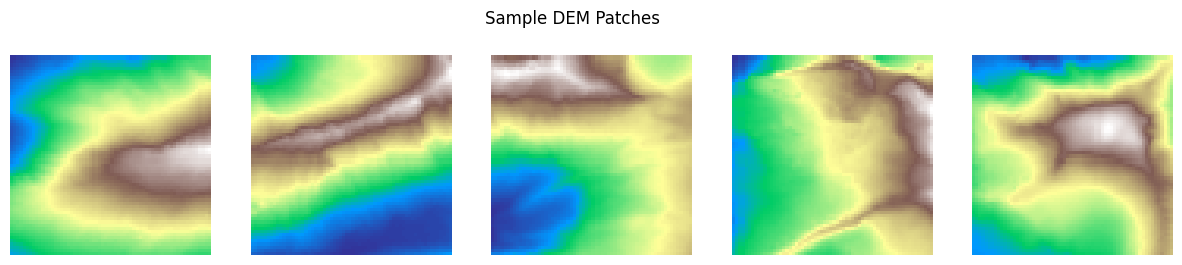

In [11]:
def patchify(img, patch_size=64):
    patches = []
    for i in range(0, img.shape[0]-patch_size, patch_size):
        for j in range(0, img.shape[1]-patch_size, patch_size):
            patches.append(img[i:i+patch_size, j:j+patch_size])
    return np.array(patches)

patches = patchify(dem_norm, 64)
print("Total patches:", patches.shape)

# Show patches
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    axs[i].imshow(patches[i], cmap="terrain")
    axs[i].axis("off")
plt.suptitle("Sample DEM Patches")
plt.show()


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class ResNet18SE(nn.Module):
    def __init__(self):
        super(ResNet18SE, self).__init__()
        base = resnet18(pretrained=True)
        # Modify the first convolutional layer to accept 1 input channel
        base.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.features = nn.Sequential(*list(base.children())[:-2])
        self.se = SEBlock(512)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 128)

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, dim=-1)


class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.encoder = ResNet18SE()

    def forward(self, x1, x2):
        z1, z2 = self.encoder(x1), self.encoder(x2)
        return z1, z2

In [16]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SiameseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CosineEmbeddingLoss()

patch_tensors = torch.tensor(patches).unsqueeze(1).float()  # shape [N,1,64,64]

for epoch in range(2):  # demo epochs
    idx1, idx2 = np.random.randint(0, len(patch_tensors), 2)
    img1, img2 = patch_tensors[idx1:idx1+1], patch_tensors[idx2:idx2+1]
    img1, img2 = img1.to(device), img2.to(device)

    z1, z2 = model(img1, img2)
    target = torch.tensor([1.0]).to(device)
    loss = criterion(z1, z2, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 0.0141
Epoch 1, Loss: 0.0109


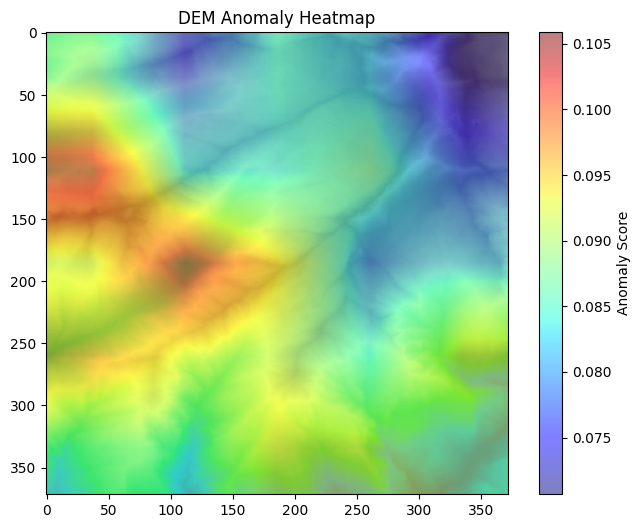

In [17]:
# ==============================================
# STEP 7: Anomaly Map
# ==============================================
import cv2

def anomaly_map(model, patches, img_shape, patch_size=64):
    embeddings = []
    for p in patches:
        t = torch.tensor(p).unsqueeze(0).unsqueeze(0).float().to(device)
        with torch.no_grad():
            emb = model.encoder(t).cpu().numpy()
        embeddings.append(emb)

    embeddings = np.array(embeddings).squeeze()
    ref = np.mean(embeddings, axis=0)
    scores = np.linalg.norm(embeddings - ref, axis=1)

    h = img_shape[0] // patch_size
    w = img_shape[1] // patch_size
    anomaly_grid = scores.reshape(h, w)
    return anomaly_grid

heatmap = anomaly_map(model, patches, dem_norm.shape)

plt.figure(figsize=(8,6))
plt.imshow(dem_norm, cmap="terrain")
plt.imshow(cv2.resize(heatmap, dem_norm.shape[::-1]), cmap="jet", alpha=0.5)
plt.colorbar(label="Anomaly Score")
plt.title("DEM Anomaly Heatmap")
plt.show()


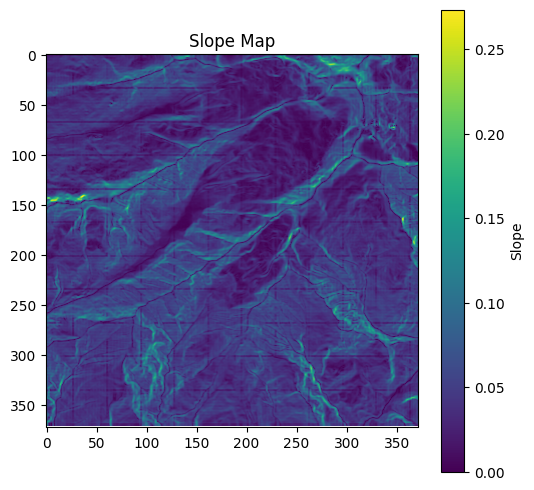

Elevation Range: 2774.0 - 6032.0
DEM Area (sq.km): 124.5456


In [18]:
# ==============================================
# STEP 8: Elevation, Slope, Area
# ==============================================
from scipy.ndimage import sobel

dx = sobel(dem_norm, axis=0)
dy = sobel(dem_norm, axis=1)
slope = np.hypot(dx, dy)

plt.figure(figsize=(6,6))
plt.title("Slope Map")
plt.imshow(slope, cmap="viridis")
plt.colorbar(label="Slope")
plt.show()

print("Elevation Range:", dem.min(), "-", dem.max())
print("DEM Area (sq.km):", dem.shape[0]*dem.shape[1]*30*30/1e6)  # if 30m resolution
